Stepping simulation:  98%|█████████▊| 3518/3600 [00:37<00:00, 108.73it/s]Event: Maximum voltage [V], Batteries: [0, 1, 2, 3, 4, 5]
High voltage limit reached
Stepping simulation:   0%|          | 0/600 [00:00<?, ?it/s]High voltage limit reached
Event: Maximum voltage [V], Batteries: [0, 1, 2, 3, 4, 5]
Stepping simulation: 100%|██████████| 90/90 [00:01<00:00, 71.36it/s]


Last State of Charge (SoC) value: 99.35%


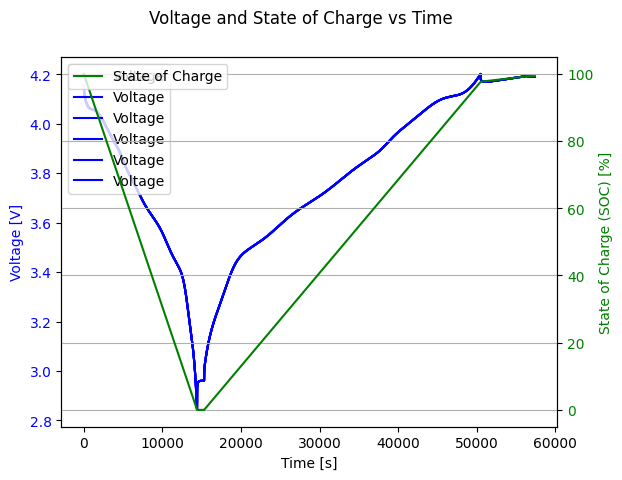

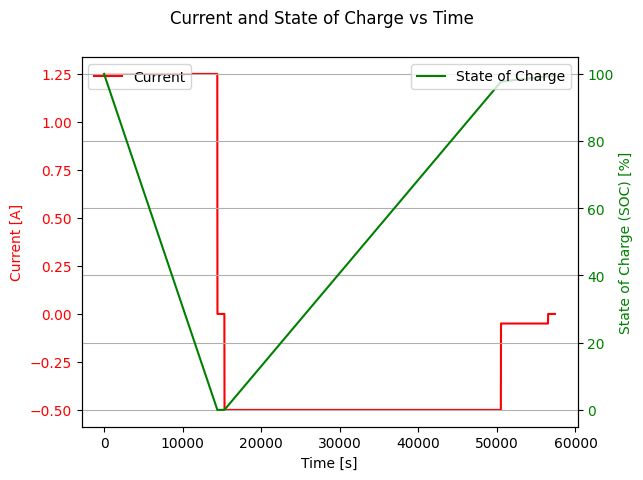

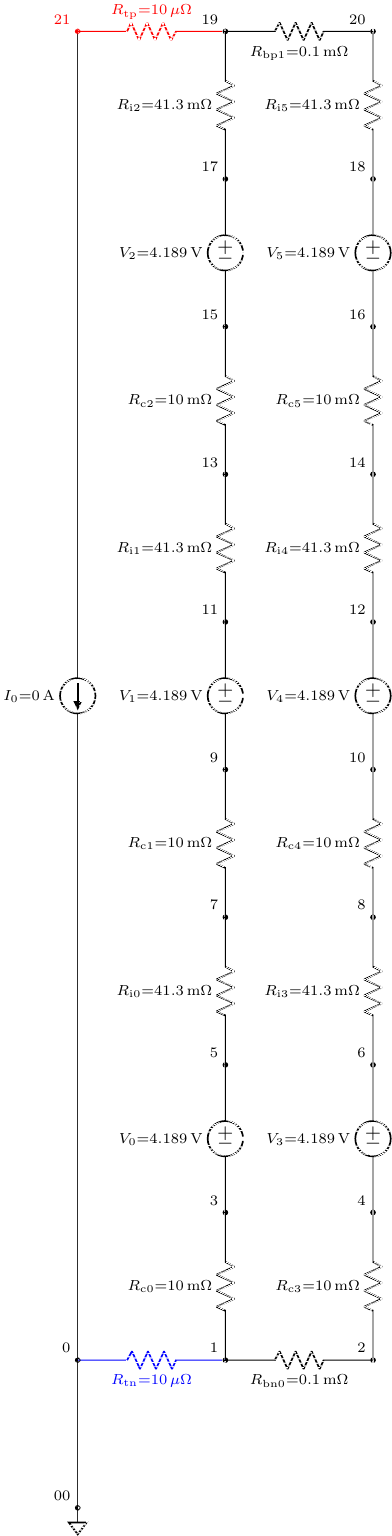

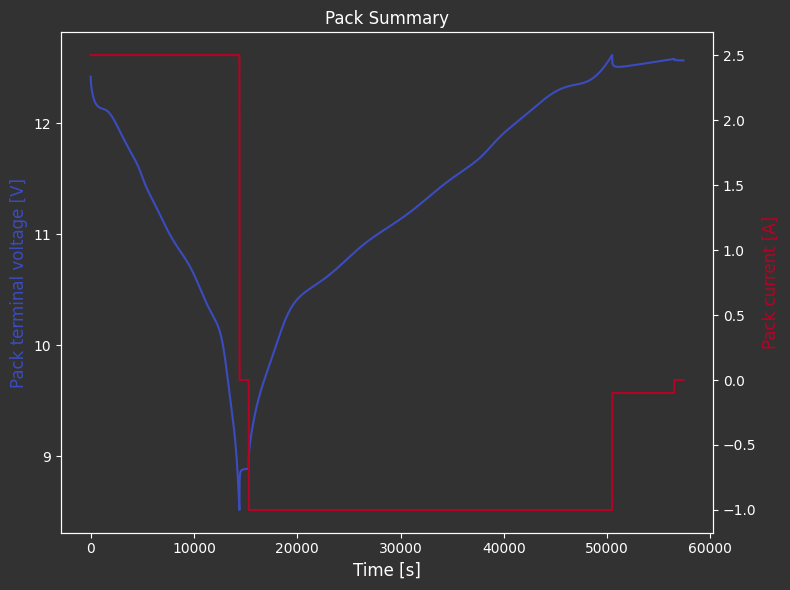

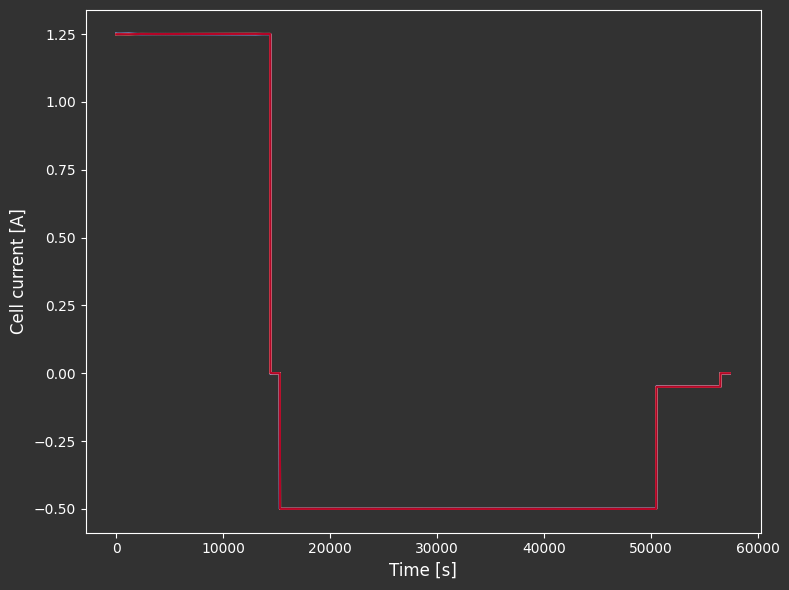

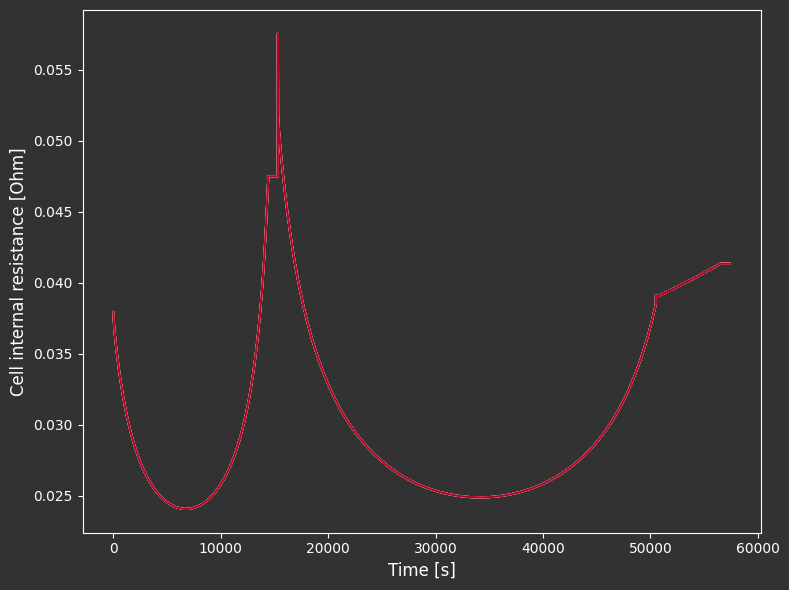

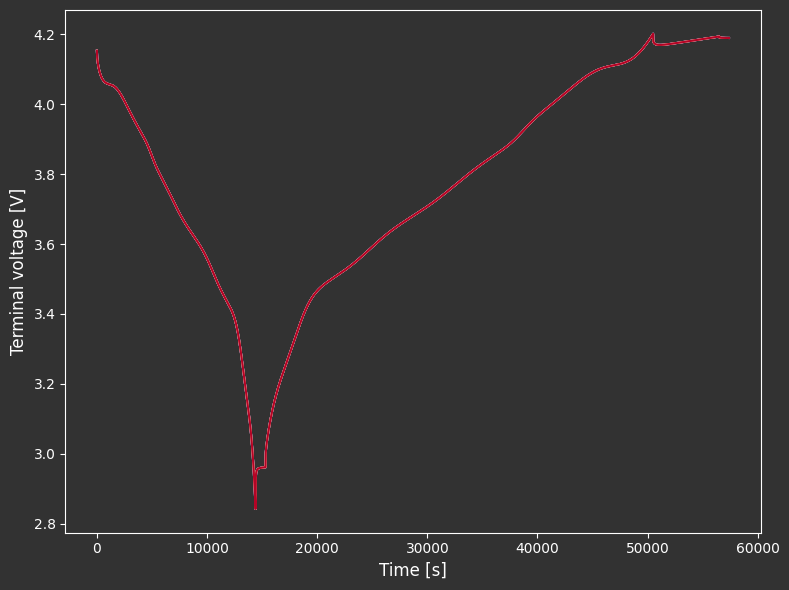

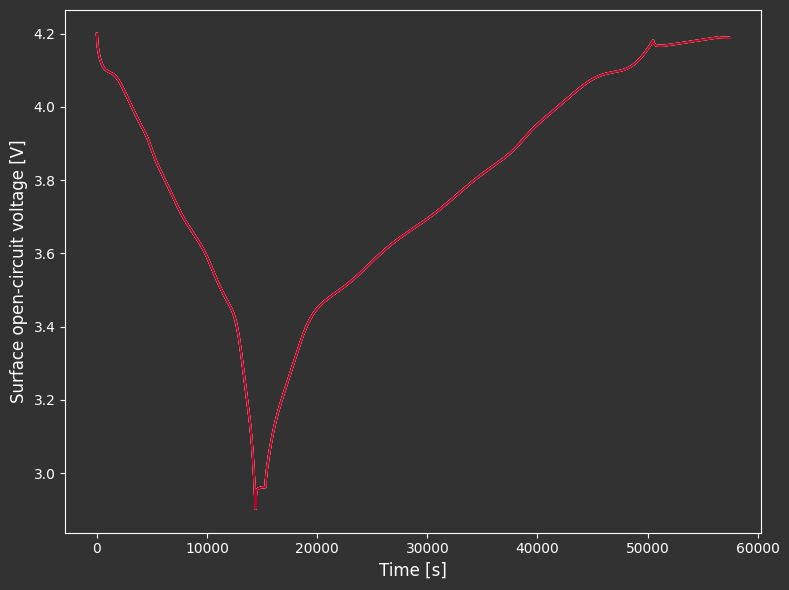

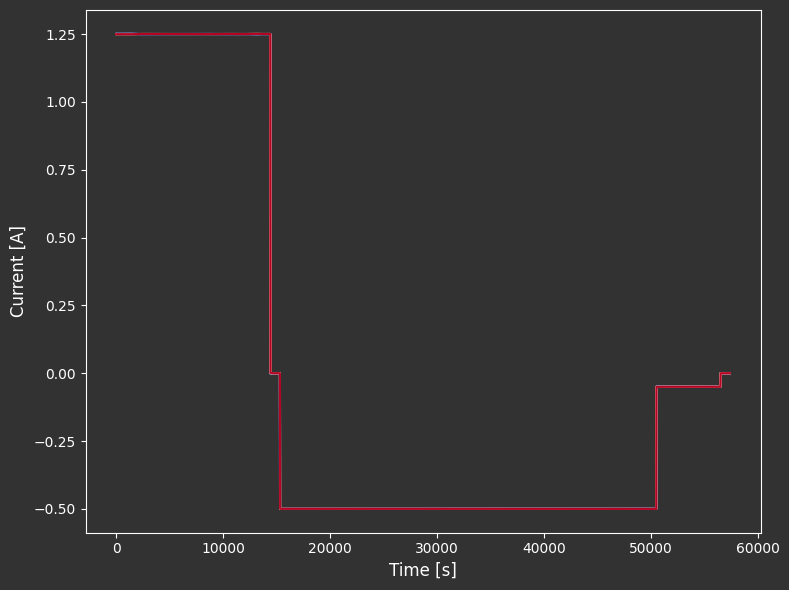

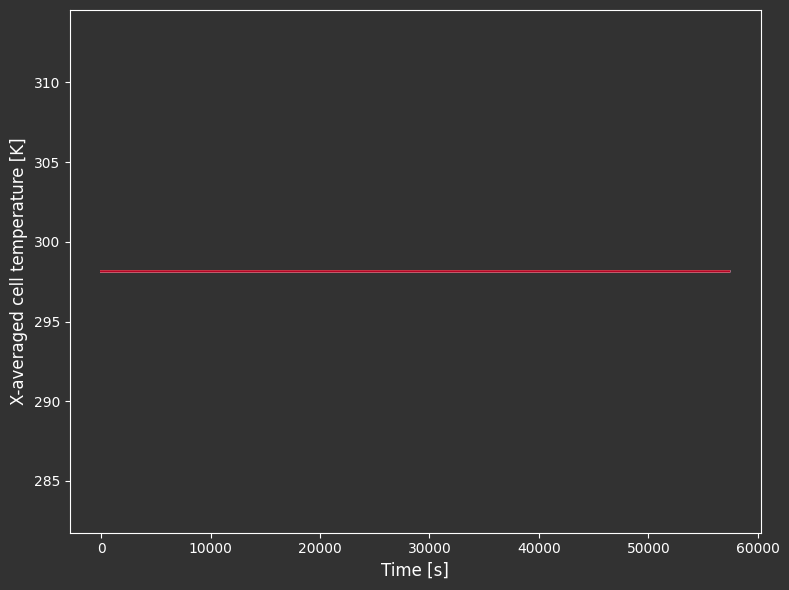

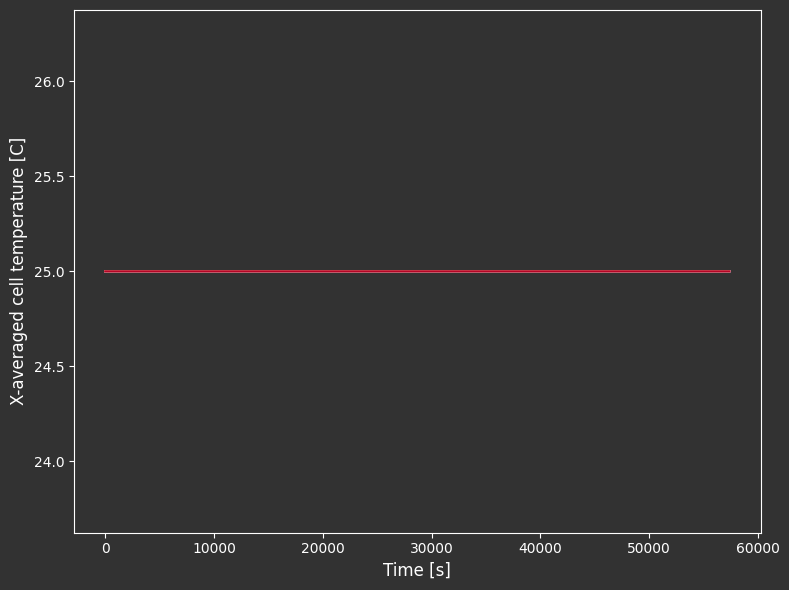

In [2]:
import pybamm
import numpy as np
import liionpack as lp
import matplotlib.pyplot as plt

def mySPMEsim(parameter_values=None):
    # Create the pybamm model
    model = pybamm.lithium_ion.SPM()

    # Add events to the model
    model = lp.add_events_to_model(model)

    # Set up parameter values
    if parameter_values is None:
        param = pybamm.ParameterValues("Chen2020")
    else:
        param = parameter_values.copy()

    # Set up solver and simulation
    solver = pybamm.CasadiSolver(mode="safe")
    sim = pybamm.Simulation(
        model=model,
        parameter_values=param,
        solver=solver,
    )
    return sim

# Generate the netlist
netlist = lp.setup_circuit(Np=2, Ns=3, Rb=1e-4, Rc=1e-2, Ri=5e-2, V=1.5, I=80.0)

# Define the parameter values
parameter_values = pybamm.ParameterValues("Chen2020")

# Define the experiment
experiment = pybamm.Experiment(
    [
        "Discharge at 2.5 A for 240 minutes",
        "Rest for 15 minutes",
        "Charge at 1 A for 600 minutes",
        "Charge at 100 mA for 100 minutes",
        "Rest for 15 minutes",
    ],
    period="10 seconds",
)

# Start with a minimal set of output variables
output_variables = [
    "Terminal voltage [V]",
    "Current [A]",
    "X-averaged cell temperature [K]",
    "X-averaged cell temperature [C]",
]

InitialSoC = 1.0

# Solve the pack using the custom simulation function
output = lp.solve(
    netlist=netlist,
    parameter_values=parameter_values,
    experiment=experiment,
    sim_func=mySPMEsim,
    output_variables=output_variables,
    initial_soc=InitialSoC
)

# print(output)

# Extract data for manual SoC calculation
time = output["Time [s]"]
current = output["Current [A]"].mean(axis=1)  # Average current across cells

# Extract battery capacity from the parameter values
battery_capacity_Ah = parameter_values["Nominal cell capacity [A.h]"]

# Convert battery capacity to amp-seconds (As)
battery_capacity_As = battery_capacity_Ah * 3600

# Calculate cumulative charge in ampere-seconds (As)
cumulative_charge_As = np.cumsum(current * np.diff(np.insert(time, 0, 0)))

# Calculate SoC as a percentage
initial_soc_as = InitialSoC * battery_capacity_As
soc = (initial_soc_as - cumulative_charge_As) / battery_capacity_As * 100

# Print the last SoC value
print("Last State of Charge (SoC) value: {:.2f}%".format(soc[-1]))

# Function to plot voltage and SoC
def plot_voltage_soc(output, soc):
    time = output["Time [s]"]
    voltage = output["Terminal voltage [V]"]

    # Plot voltage and SoC vs time on the same graph
    fig, ax1 = plt.subplots()

    ax1.plot(time, voltage, 'b-', label='Voltage')
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Voltage [V]', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    ax2 = ax1.twinx()  # Instantiate a second y-axis that shares the same x-axis
    ax2.plot(time, soc, 'g-', label='State of Charge')
    ax2.set_ylabel('State of Charge (SOC) [%]', color='g')
    ax2.tick_params(axis='y', labelcolor='g')

    # Adding a title and legend
    fig.suptitle('Voltage and State of Charge vs Time')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper left')

    plt.grid(True)
    plt.show()

# Function to plot current and SoC
def plot_current_soc(output, soc):
    time = output["Time [s]"]
    current = output["Current [A]"].mean(axis=1)  # Average current across cells

    # Plot current and SoC vs time on the same graph
    fig, ax1 = plt.subplots()

    ax1.plot(time, current, 'r-', label='Current')
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Current [A]', color='r')
    ax1.tick_params(axis='y', labelcolor='r')

    ax2 = ax1.twinx()  # Instantiate a second y-axis that shares the same x-axis
    ax2.plot(time, soc, 'g-', label='State of Charge')
    ax2.set_ylabel('State of Charge (SOC) [%]', color='g')
    ax2.tick_params(axis='y', labelcolor='g')

    # Adding a title and legend
    fig.suptitle('Current and State of Charge vs Time')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.grid(True)
    plt.show()

# Plot the standard output, voltage/SoC graph, and current/SoC graph
plot_voltage_soc(output, soc)
plot_current_soc(output, soc)
lp.plot_output(output)

# Draw the circuit
lp.draw_circuit(netlist, cpt_size=1.0, dpi=150, node_spacing=2.5)
plt.show()